In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
!pip install PyPDF2
!pip install python-docx
!pip install pycryptodome

In [3]:
train_path = '/content/drive/MyDrive/GAIPAL/DATA/TRAIN/GAIPAL_Policies/'
test_path = '/content/drive/MyDrive/GAIPAL/DATA/TEST/'

In [4]:
import os
import re

import docx
import PyPDF2
import torch
from collections import Counter
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from Crypto.Cipher import AES

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.cluster import KMeans

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def extract_text_from_pdf(pdf_path):
    text = ""
    with open(pdf_path, "rb") as file:
        reader = PyPDF2.PdfReader(file)
        for page_num in range(len(reader.pages)):
            text += reader.pages[page_num].extract_text()
    return text

def extract_text_from_docx(docx_path):
    doc = docx.Document(docx_path)
    text = ""
    for paragraph in doc.paragraphs:
        text += paragraph.text + "\n"
    return text

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    tokenized_texts = re.findall(r'\b\w+\b', text)
    stop_words = set(stopwords.words('english'))
    filtered_texts = [' '.join([word for word in tokens.split() if word not in stop_words]) for tokens in tokenized_texts]
    return filtered_texts

def build_dataset(file_paths):
    documents = []
    run_sum = 0
    for file_path in file_paths:
        if file_path.endswith(".pdf"):
            text = extract_text_from_pdf(file_path)
        elif file_path.endswith(".docx"):
            text = extract_text_from_docx(file_path)
        else:
            print(file_path, " doesn't end in .pdf or .docx")
        text = preprocess_text(text)
        run_sum +=len(text)
        documents.append(text)

    return documents

def word_counter(array_of_text):
    word_freq = Counter()
    for text in array_of_text:
        text = [text for text in text if text]
        text = [text for text in text if len(text)>1 and bool(re.match("^[a-zA-Z]+$", text))]
        word_freq.update(text)
    return word_freq


# TRAIN EDA

In [6]:
files = os.listdir(train_path)
train_file_paths = []
for file_name in files:
  train_file_paths.append(os.path.join(train_path, file_name))

In [7]:
train_docs = build_dataset(train_file_paths)

In [8]:
frequent_words = word_counter(train_docs)

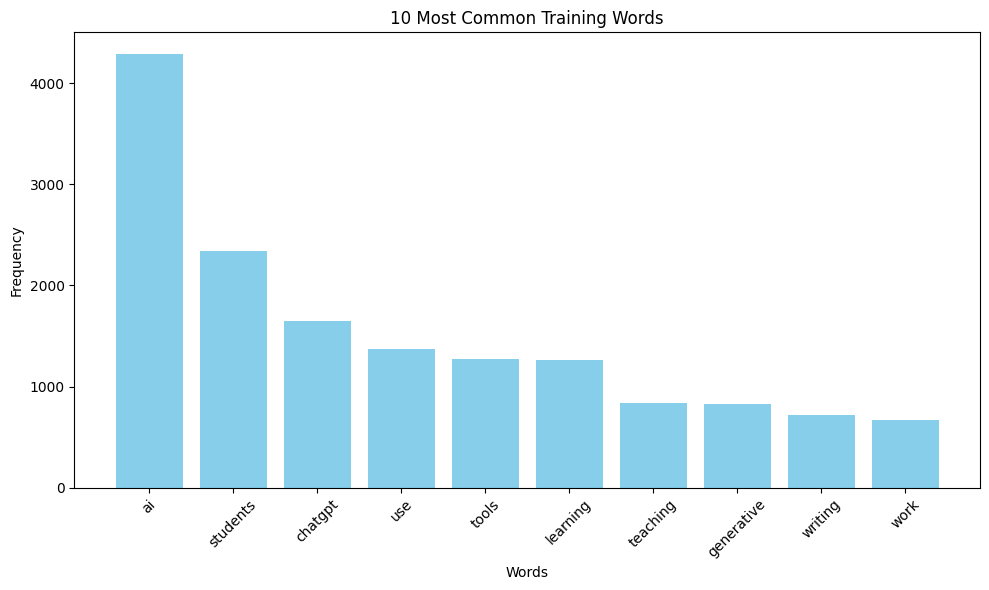

In [9]:
most_common_words = frequent_words.most_common(10)

words = [word[0] for word in most_common_words]
frequencies = [word[1] for word in most_common_words]

plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('10 Most Common Training Words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Test EDA

In [10]:
folders = os.listdir(test_path)
test_file_paths = []
for folder_name in folders:
  files = os.listdir(test_path+folder_name)
  for file_name in files:
    test_file_paths.append(os.path.join(test_path,folder_name, file_name))

In [11]:
test_docs = build_dataset(test_file_paths)

In [12]:
frequent_words = word_counter(test_docs)

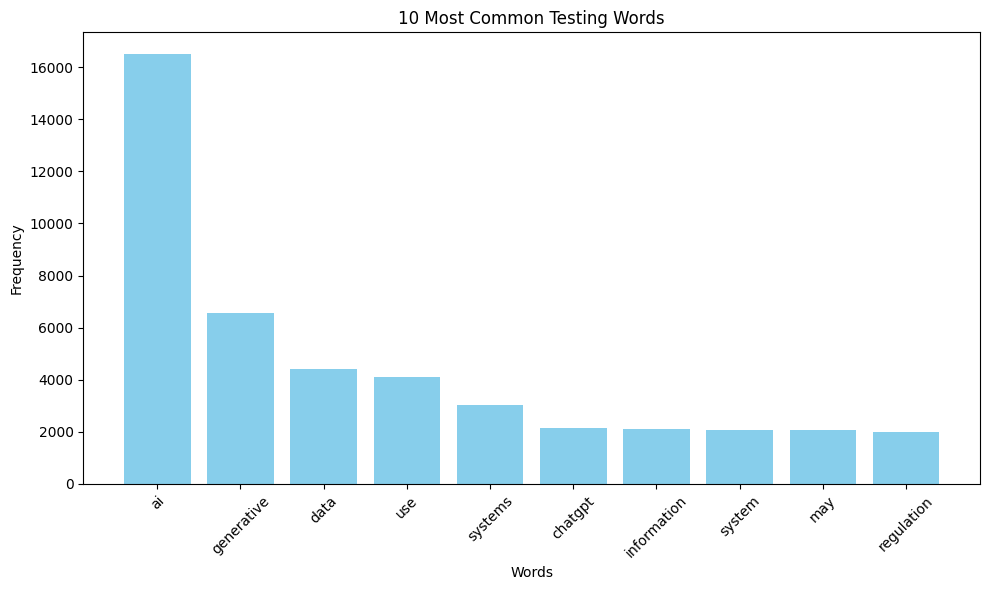

In [13]:
most_common_words = frequent_words.most_common(10)

words = [word[0] for word in most_common_words]
frequencies = [word[1] for word in most_common_words]

plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('10 Most Common Testing Words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The difference between the two charts show the expected changes between documents mainly related to school policy in the train set,versus the government, military, and business documents in the test set.

### Document Count Statistics
Testing document numbers, Non_profits_and_NGOs: 7

Testing document numbers, Government_and_International_Orgs: 49

Testing document numbers, Education_and_Academia(colleges_and_universities): 40

Testing document numbers, Business_and_Professional_Orgs: 27

Training document numbers, 102

## TF-IDF
TF-IDF is a useful method for finding significant keywords among individual documents.

In [14]:
def tf_idf(docs):
    tfidf_vectorizer = TfidfVectorizer()
    docs = [' '.join(doc) for doc in docs]
    tfidf_matrix = tfidf_vectorizer.fit_transform(docs)

    tfidf_matrix_array = tfidf_matrix.toarray()
    feature_names = tfidf_vectorizer.get_feature_names_out()

    return feature_names,tfidf_matrix_array

In [15]:
feature_names_train, tf_idf_train = tf_idf(train_docs)

In [16]:
def top_n_words_for_document(tf_idf_matrix, feature_names, document_index, n=3):
    tf_idf_values = tf_idf_matrix[document_index]
    top_indices = tf_idf_values.argsort()[-n:][::-1]
    top_words = [feature_names[i] for i in top_indices]

    return top_words

In [17]:
for i in range(10):
  top_words = top_n_words_for_document(tf_idf_train, feature_names_train,i)
  print("Top 3 words for "+train_file_paths[i].rsplit('/')[-1]+":", top_words)

Top 3 words for wake_forest_uni_chatgpt_data_protection.docx: ['data', 'identifiable', 'information']
Top 3 words for umich_gen_ai.docx: ['genai', 'policies', 'misconduct']
Top 3 words for washu_addresses_ai_technology.docx: ['washu', 'ai', 'tools']
Top 3 words for william_mary_studio_teaching_in_the_age_of_gen_ai.docx: ['aids', 'content', 'generated']
Top 3 words for unl-ai.docx: ['mean', 'higher', 'difficult']
Top 3 words for wharton doc.docx: ['wharton', 'program', 'business']
Top 3 words for uarizona-gen-ai-teaching.docx: ['ai', 'students', 'arizona']
Top 3 words for upitt-ai-resources.docx: ['generative', 'pitt', 'ai']
Top 3 words for uchicago_combating_academic_dishonesty_chatgpt.docx: ['chatgpt', 'ai', 'writing']
Top 3 words for wustl_message_for_research_regarding_ai.docx: ['research', 'ai', 'chancellor']


This shows the most specific words for the first 10 documents in the train set.

In [18]:
feature_names_test, tf_idf_test = tf_idf(test_docs)
for i in range(10):
  top_words = top_n_words_for_document(tf_idf_test, feature_names_test,i)
  print("Top 3 words for "+test_file_paths[i].rsplit('/')[-1]+":", top_words)

Top 3 words for Generative-AI-Checklist - Future of Privacy Forum.pdf: ['ai', 'generative', 'checklist']
Top 3 words for GenAI-Guidelines-June2023.pdf: ['𝒚𝒊isdone', 'documenta', 'dmin']
Top 3 words for PR-Council-Guidelines-on-Generative-AI-042423.pdf: ['ai', 'generative', 'client']
Top 3 words for FrameworkOfAnAcceptableUsePolicyForExternalGenerativeAI.pdf: ['systems', 'employees', 'generative']
Top 3 words for 2023-12-15-Civic-Tech-Declining-Teacher-Trust-In-Students-issue-brief-final.pdf: ['teachers', 'students', 'percent']
Top 3 words for from-promise-to-practice.pdf: ['ai', 'organisations', 'governance']
Top 3 words for 5.-Resolution-on-Generative-AI-Systems-101023.pdf: ['deployers', 'data', 'generative']
Top 3 words for City-of-Seattle-Generative-Artificial-Intelligence-Policy.pdf: ['city', 'ai', 'seattle']
Top 3 words for San Jose Generative AI Guidelines.pdf: ['city', 'ai', 'generative']
Top 3 words for New Jersey GenAI Policy.pdf: ['ai', 'use', 'generative']


Likewise, the most specific words for the first 10 documents in the test set.

## Another Visualization Tool: K-Means Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


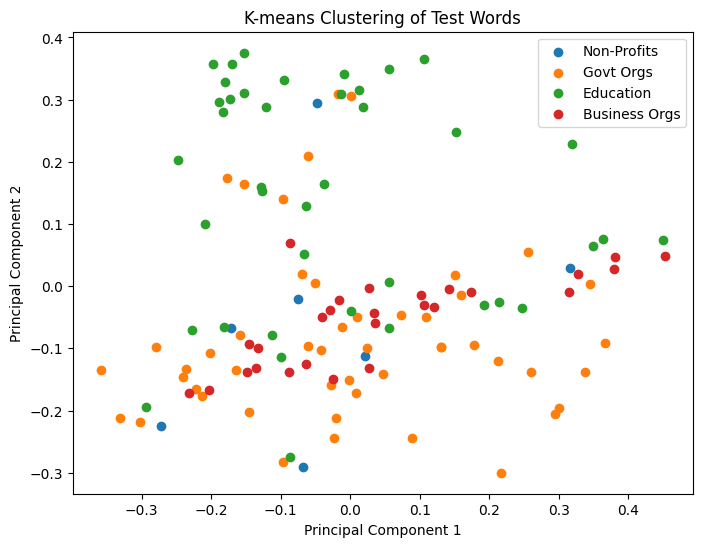

In [19]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
tfidf_matrix_2d = pca.fit_transform(tf_idf_test)

k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(tf_idf_test)

plt.figure(figsize=(8, 6))
start_ind = 0
end_ind = 7
plt.scatter(tfidf_matrix_2d[start_ind:end_ind, 0], tfidf_matrix_2d[start_ind:end_ind, 1], label = 'Non-Profits')

start_ind = end_ind
end_ind = start_ind+49
plt.scatter(tfidf_matrix_2d[start_ind:end_ind, 0], tfidf_matrix_2d[start_ind:end_ind, 1], label = 'Govt Orgs')

start_ind = end_ind
end_ind = start_ind+40
plt.scatter(tfidf_matrix_2d[start_ind:end_ind, 0], tfidf_matrix_2d[start_ind:end_ind, 1], label = 'Education')

start_ind = end_ind
end_ind = start_ind+27
plt.scatter(tfidf_matrix_2d[start_ind:end_ind, 0], tfidf_matrix_2d[start_ind:end_ind, 1], label = 'Business Orgs')

plt.title('K-means Clustering of Test Words')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
#plt.colorbar(label='Test Group')
plt.show()

The above K-means clustering shows how each TF-IDF looks among folders in the test set. Ideally, they'd be completely separable, but obviously, the common themes of AI, GenAI, and privacy are prevalent among most if not all.

## Word Cloud

Using a word cloud also allows us to see which words and phrases appear most often in the dataset. In filtering through these words, we removed words of length 1, numbers, and English stopwords.

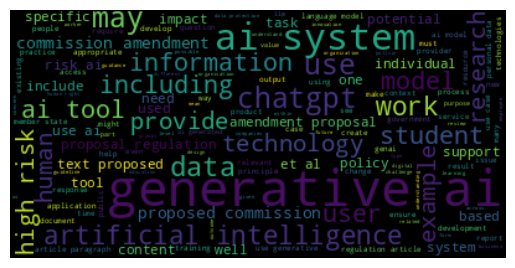

In [21]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

flattened_test_docs = [item for items in test_docs for item in items if len(item) != 1 and (not item.isnumeric()) and item not in stopwords.words('english')]

all_test_words = ' '.join(flattened_test_docs)

wordcloud = WordCloud().generate(all_test_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()